In [1]:
import torch
import os
import torch.nn.functional as F
from torchvision.transforms.functional import perspective as perspective_transform
from torchvision.transforms.functional import rotate, resize, center_crop
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Sequence, Optional, Union, Tuple

In [2]:
''' 添加Rician噪声 '''
def add_rician_noise(image, mean=0, std=25):
    image = image.float()
    # 生成高斯噪声并添加到图像上
    noise_real  = torch.randn_like(image) * std + mean
    noise_imaginary = torch.randn_like(image) * std + mean
    noisy_image = torch.sqrt((image + noise_real)**2 + noise_imaginary**2)
    # 将像素值裁剪到 [0, 1] 范围内
    # noisy_image = torch.clamp(noisy_image, 0, 1)
    # print("std:", std)
    return noisy_image

In [3]:
''' 生成随机掩膜 '''
def generate_random_mask(center_fractions: Sequence[float], accelerations: Sequence[int], num_cols: int, seed: Optional[Union[int, Tuple[int, ...]]] = None) -> torch.Tensor:
    if len(center_fractions) != len(accelerations):
        raise ValueError("Number of center fractions should match number of accelerations")

    rng = np.random.RandomState(seed)
    choice = rng.randint(0, len(accelerations))
    center_fraction = center_fractions[choice]
    acceleration = accelerations[choice]

    num_low_freqs = int(round(num_cols * center_fraction))
    prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)

    mask = rng.uniform(size=num_cols) < prob
    pad = (num_cols - num_low_freqs + 1) // 2
    mask[pad: pad + num_low_freqs] = True

    mask_shape = [1, 1] + [1] * (len(mask.shape) - 2)
    mask_shape[-2] = num_cols
    mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

    # print("Generated Random Mask:")
    # print(mask)
    print(f"Center Fraction: {center_fraction}, Acceleration: {acceleration}")
    true_count = int(mask.sum())
    print(f"Number of True values in the mask: {true_count}")

    return mask

In [26]:
''' 随机运动伪影 '''
def random_motion_transform(image, width, height,
                            rotate_prob = 0.4, rotate_range = [-1, 1],
                            translation_prob = [0.1, 0.1, 0.8], translation_range = [-0.03, 0.03],
                            perspective_prob = [0.0, 0.0, 1.0], perspective_range = [-0.01, 0.01],
                            stretch_prob = 0.0, stretch_range = [-0.01, 0.01]):
    # 旋转图像 rotate
    if np.random.uniform(0, 1) < rotate_prob:
        rotate_angle = np.random.uniform(rotate_range[0], rotate_range[1])
        out = rotate(image, rotate_angle, interpolation=InterpolationMode.BILINEAR)
    else:
        out = image

    # 平移图像 translation
    translation_type = np.random.choice(["left-right", "up-down", "keep"], p=translation_prob)
    translation_rate = np.random.uniform(-translation_range[0], translation_range[0])
    if translation_type == "left-right":
        out = out.roll(int(translation_rate * width), 2)
    elif translation_type == "up-down":
        out = out.roll(int(translation_rate * height), 1)
    else:
        out = out

    # 透视变换 perspective
    original_pts = [[0, 0], [width, 0], [0, height], [width, height]]
    perspective_type = np.random.choice(["pitch", "yaw", "keep"], p=perspective_prob)
    pitch_rate1 = np.random.uniform(-perspective_range[0], perspective_range[0])
    pitch_rate2 = np.random.uniform(-perspective_range[0], perspective_range[0])
    yaw_rate1 = np.random.uniform(-perspective_range[1], perspective_range[1])
    yaw_rate2 = np.random.uniform(-perspective_range[1], perspective_range[1])
    if np.random.uniform(0, 1) < stretch_prob:
        stretch_rate1 = np.random.uniform(stretch_range[0], stretch_range[1])
        stretch_rate2 = np.random.uniform(stretch_range[0], stretch_range[1])
    else:
        stretch_rate1 = 0
        stretch_rate2 = 0
    if perspective_type == "pitch":
        pitch_pts = [
            [0 - pitch_rate1 * width, 0 - stretch_rate1 * height],
            [width + pitch_rate1 * width, 0 - stretch_rate1 * height],
            [0 - pitch_rate2 * width, height + stretch_rate2 * height],
            [width + pitch_rate2 * width, height + stretch_rate2 * height],
        ]
        yaw_pts = original_pts
        out = perspective_transform(out, original_pts, pitch_pts)
    elif perspective_type == "yaw":
        yaw_pts = [
            [0 - stretch_rate1 * width, 0 - yaw_rate1 * height],
            [width + stretch_rate2 * width, 0 - yaw_rate2 * height],
            [0 - stretch_rate1 * width, height + yaw_rate1 * height],
            [width + stretch_rate2 * width, height + yaw_rate2 * height],
        ]
        pitch_pts = original_pts
        out = perspective_transform(out, original_pts, yaw_pts)
    else:
        pitch_pts = original_pts
        yaw_pts = original_pts
        stretch_pts = [
            [0 , 0 - stretch_rate1 * height],
            [width, 0 - stretch_rate1 * height],
            [0 , height + stretch_rate2 * height],
            [width, height + stretch_rate2 * height],
        ]
        out = perspective_transform(out, original_pts, stretch_pts)

    return out

In [12]:
def kspace_scan(image_tensor, K_data, cur_round, step=4, Gp='v'):

    k_data = torch.fft.fft2(image_tensor, dim=(-2, -1))
    k_data = torch.fft.fftshift(k_data, dim=(-2, -1))

    # 计算当前应该填充的行范围
    start_row = cur_round
    end_row = cur_round + step
    # print(start_row, end_row)

    # 截取并填充到K_data中
    if Gp == 'v':
        K_data[:, start_row:end_row, :] = k_data[:, start_row:end_row, :]
    elif Gp == 'h':
        K_data[:, :, start_row:end_row] = k_data[:, :, start_row:end_row]
    else :
        print('Error: Gp should be either "v" or "h"')

    return K_data


In [27]:
def apply_motion_and_reconstruct(combined_image, rounds=64, Gp = 'v',step = 4):

    K_data = torch.zeros_like(combined_image, dtype=torch.complex128)
    width, height = combined_image.shape[-2], combined_image.shape[-1]
    if Gp == 'v':
        rounds = height
    elif Gp == 'h':
        rounds = width
    else:
        raise ValueError("Gp should be 'v' or 'h'")

    for cur_phase in range(0, rounds, step):
        if cur_phase > rounds * (31/64) and cur_phase < rounds * (33/64):
            K_data = kspace_scan(combined_image, K_data, cur_phase, step=step, Gp=Gp)
        else:
            out_image = random_motion_transform(combined_image, width, height)
            combined_result = out_image
            K_data = kspace_scan(combined_result, K_data, cur_phase, step=step, Gp=Gp)
    combined_k_data = torch.fft.fft2(combined_image, dim=(-2, -1))
    combined_k_data = torch.fft.fftshift(combined_k_data, dim=(-2, -1))
    K_data[:, width * (22//64):width * (42//64), :] = combined_k_data[:, width * (25//64):width * (39//64), :]
    reconstructed_image = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(K_data, dim=(-2, -1)), dim=(-2, -1)))

    return reconstructed_image

In [28]:
# 定义函数处理图像
def process_image(image_path):
    # 读取图像
    image = Image.open(image_path).convert("L")
    # rot90
    #image = rotate(image, 90, interpolation=InterpolationMode.BILINEAR)
    # to tensor
    image = torch.tensor(np.array(image), dtype=torch.float32)
    # 增加通道维度
    image = image.unsqueeze(0)
    motion_image = apply_motion_and_reconstruct(image)
    # noisy_image = add_rician_noise(motion_image)
    return motion_image

# 输入和输出目录
input_directory = r"O:\MICCAI2024\Real-Motion-01\datasets\motion02\run01_h"
output_directory = r"O:\MICCAI2024\Real-Motion-01\datasets\motion02\run01_58"

# 确保输出目录存在，如果不存在则创建
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# 获取目录下所有文件
files = os.listdir(input_directory)

# 循环处理每个文件
for file in files:
    if file.endswith(".png"):
        # 构建完整的输入和输出文件路径
        input_file_path = os.path.join(input_directory, file)
        output_file_path = os.path.join(output_directory, file)
        # 处理图像
        processed_image = process_image(input_file_path)
        # 删除通道维度
        processed_image = processed_image.squeeze(0)
        # 保存处理后的图像
        cv2.imwrite(output_file_path, processed_image.numpy())

print("Processing complete.")


KeyboardInterrupt: 

(3, 512, 512)


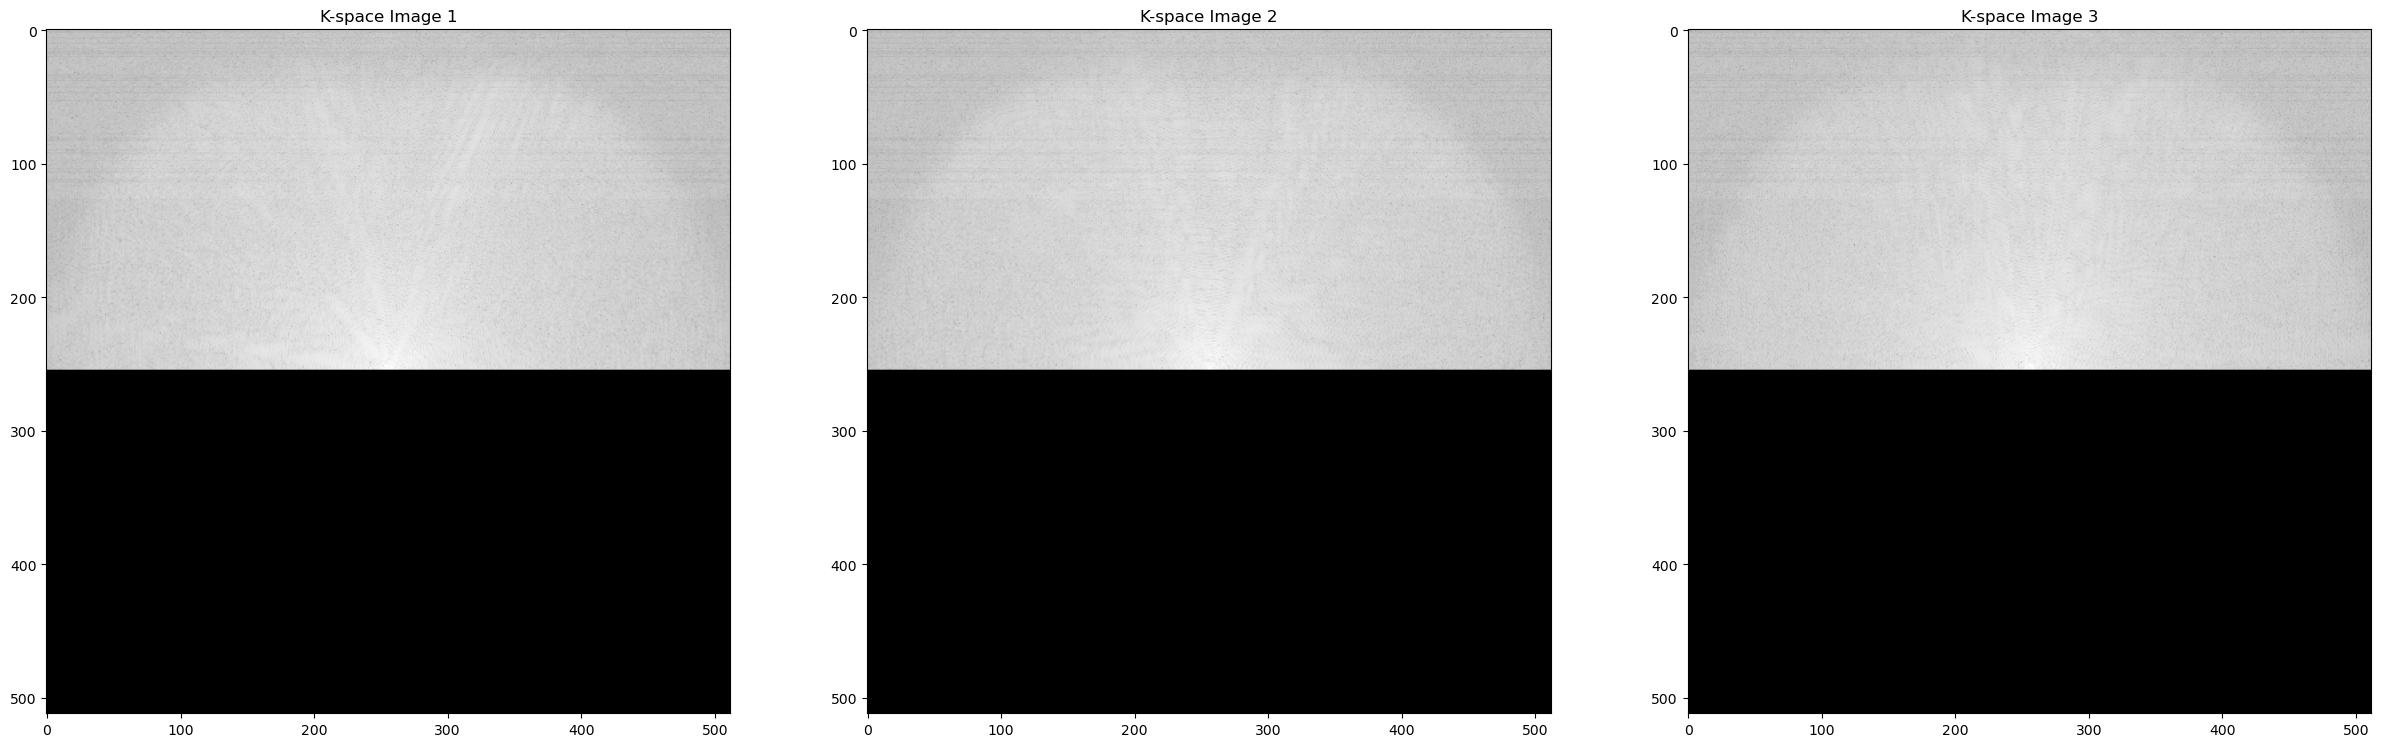

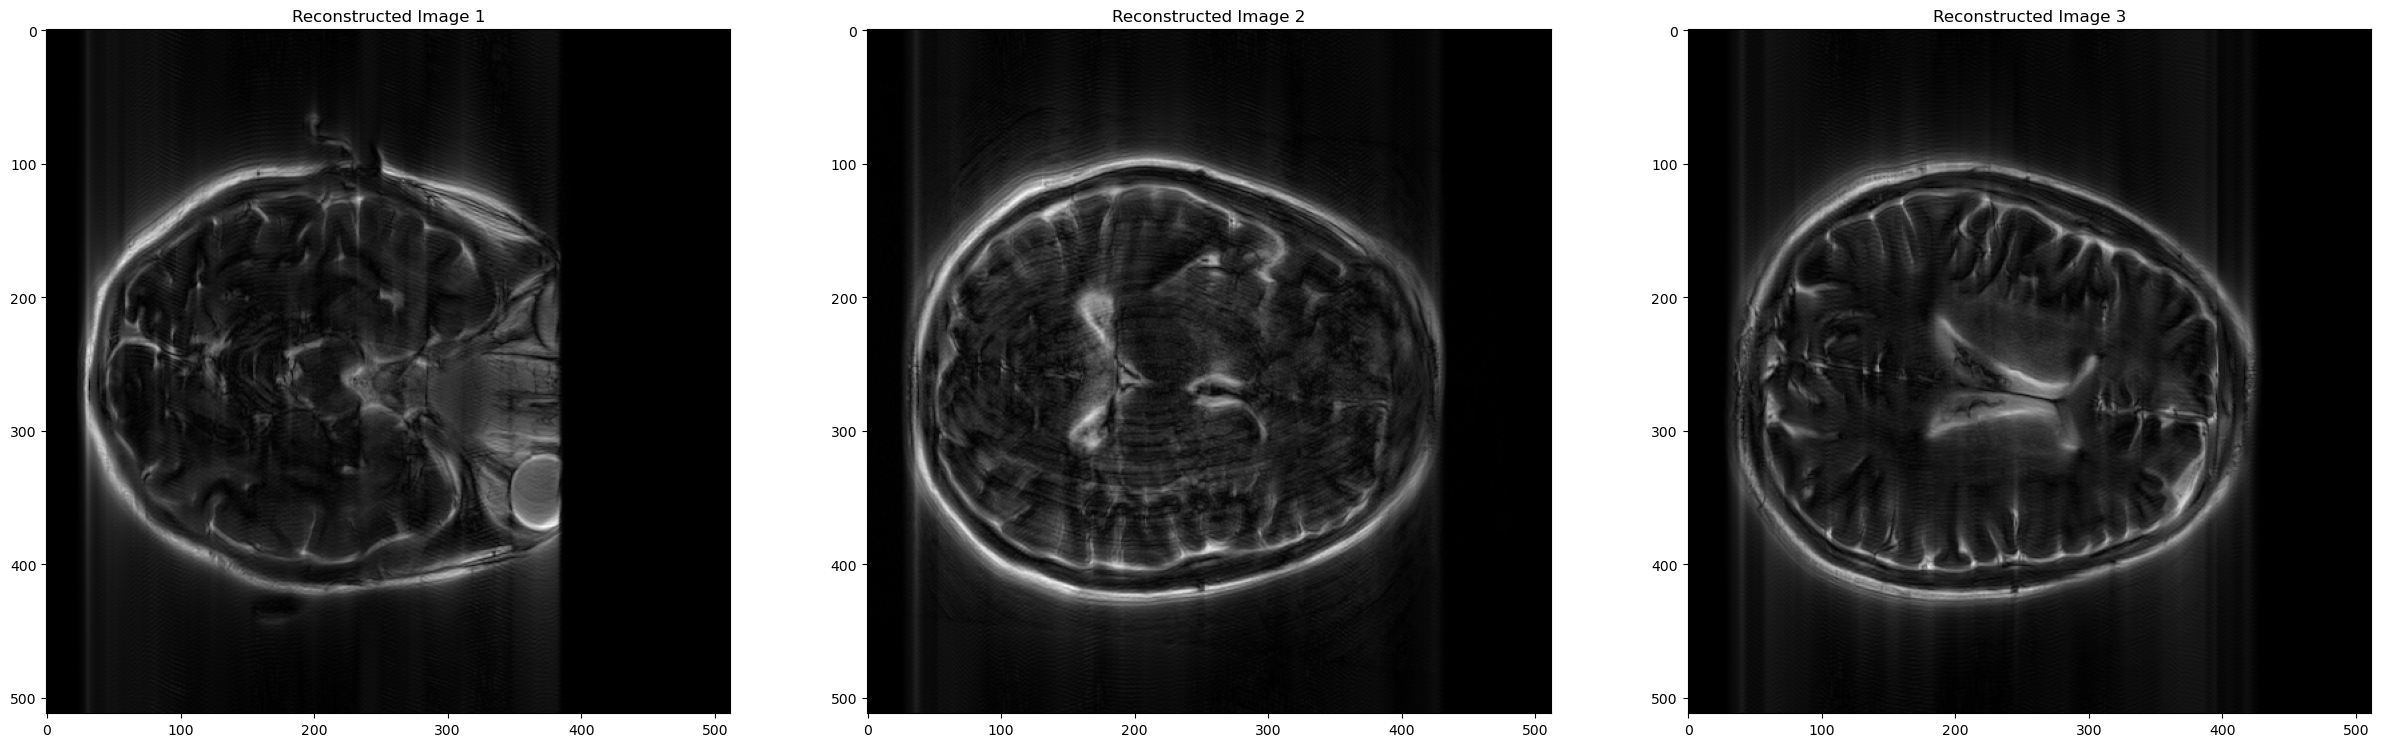

done
Center Fraction: 0.04, Acceleration: 8
Number of True values in the mask: 61
(512, 512)


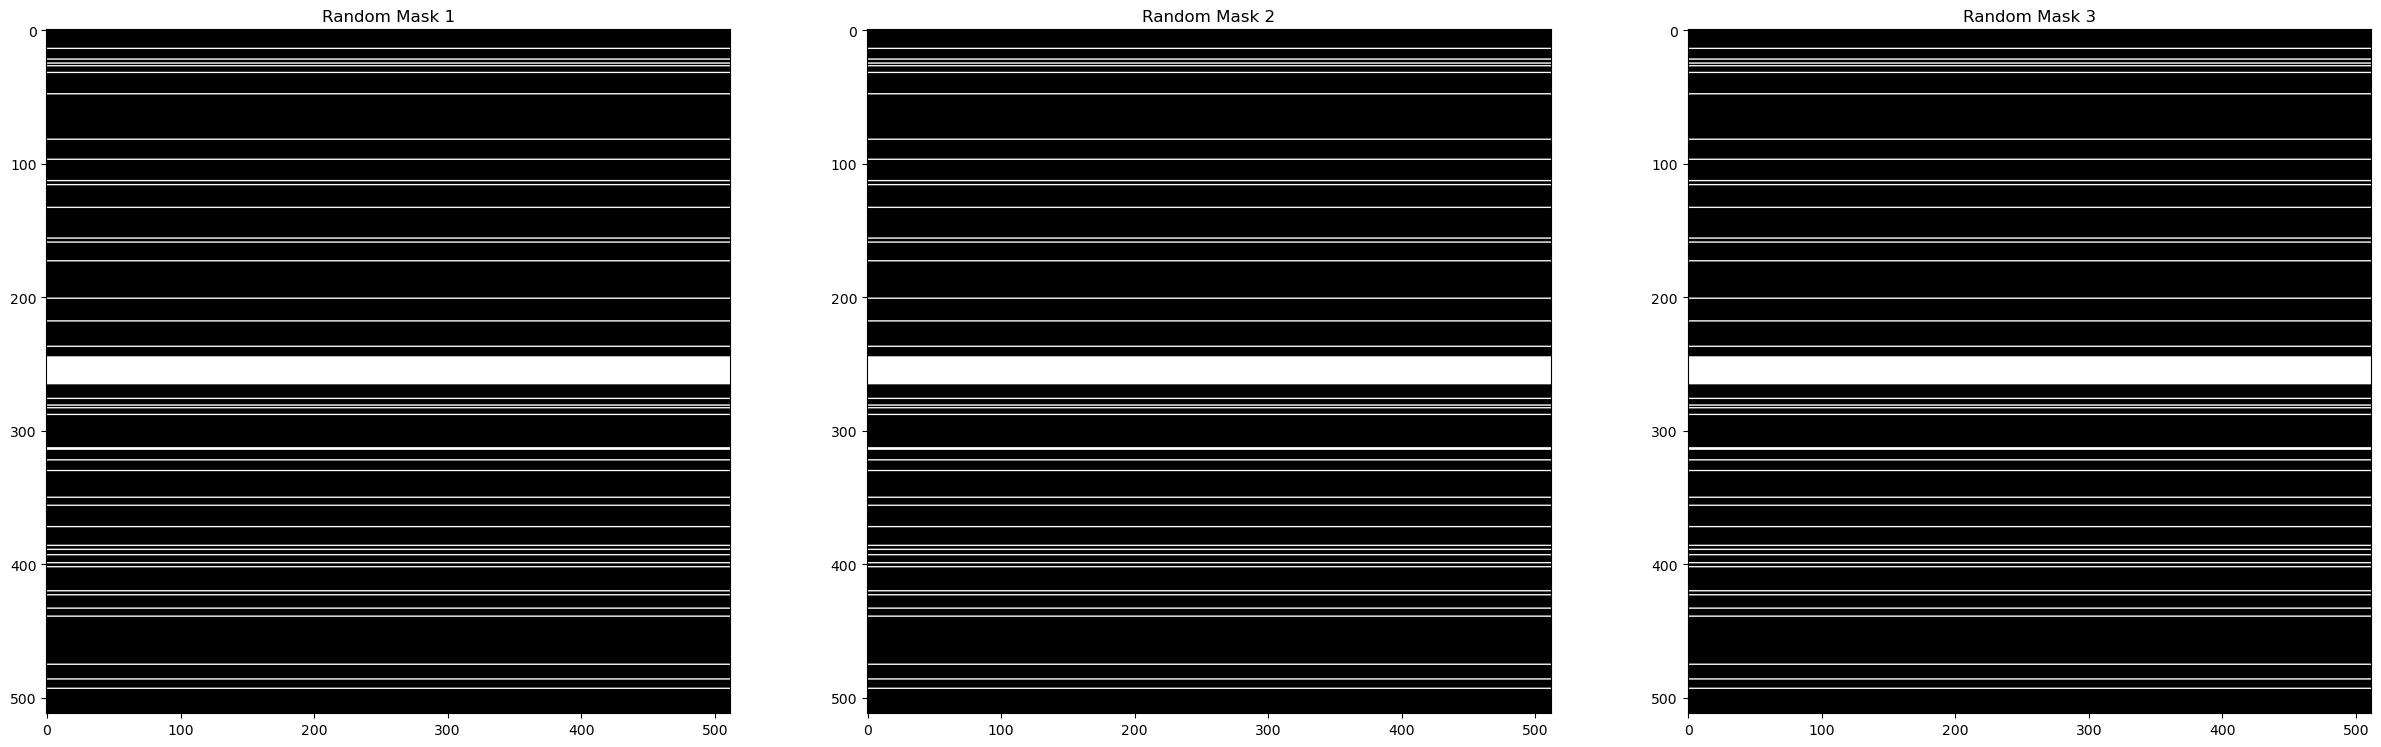

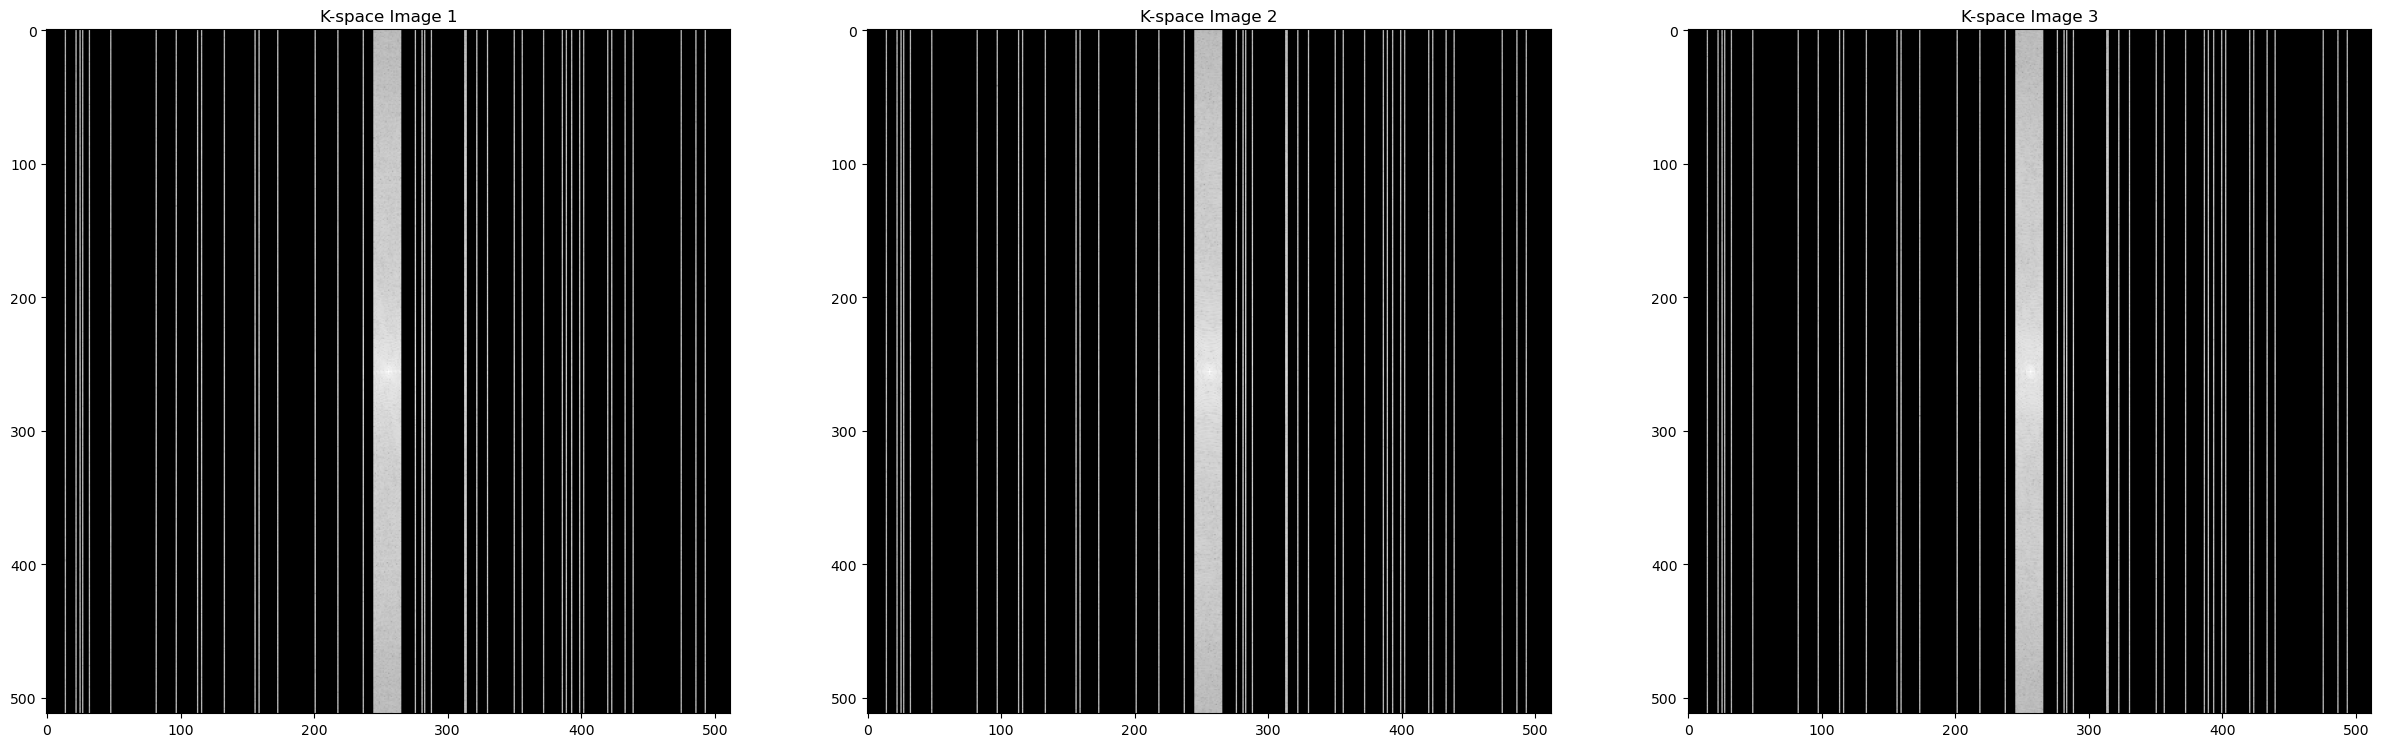

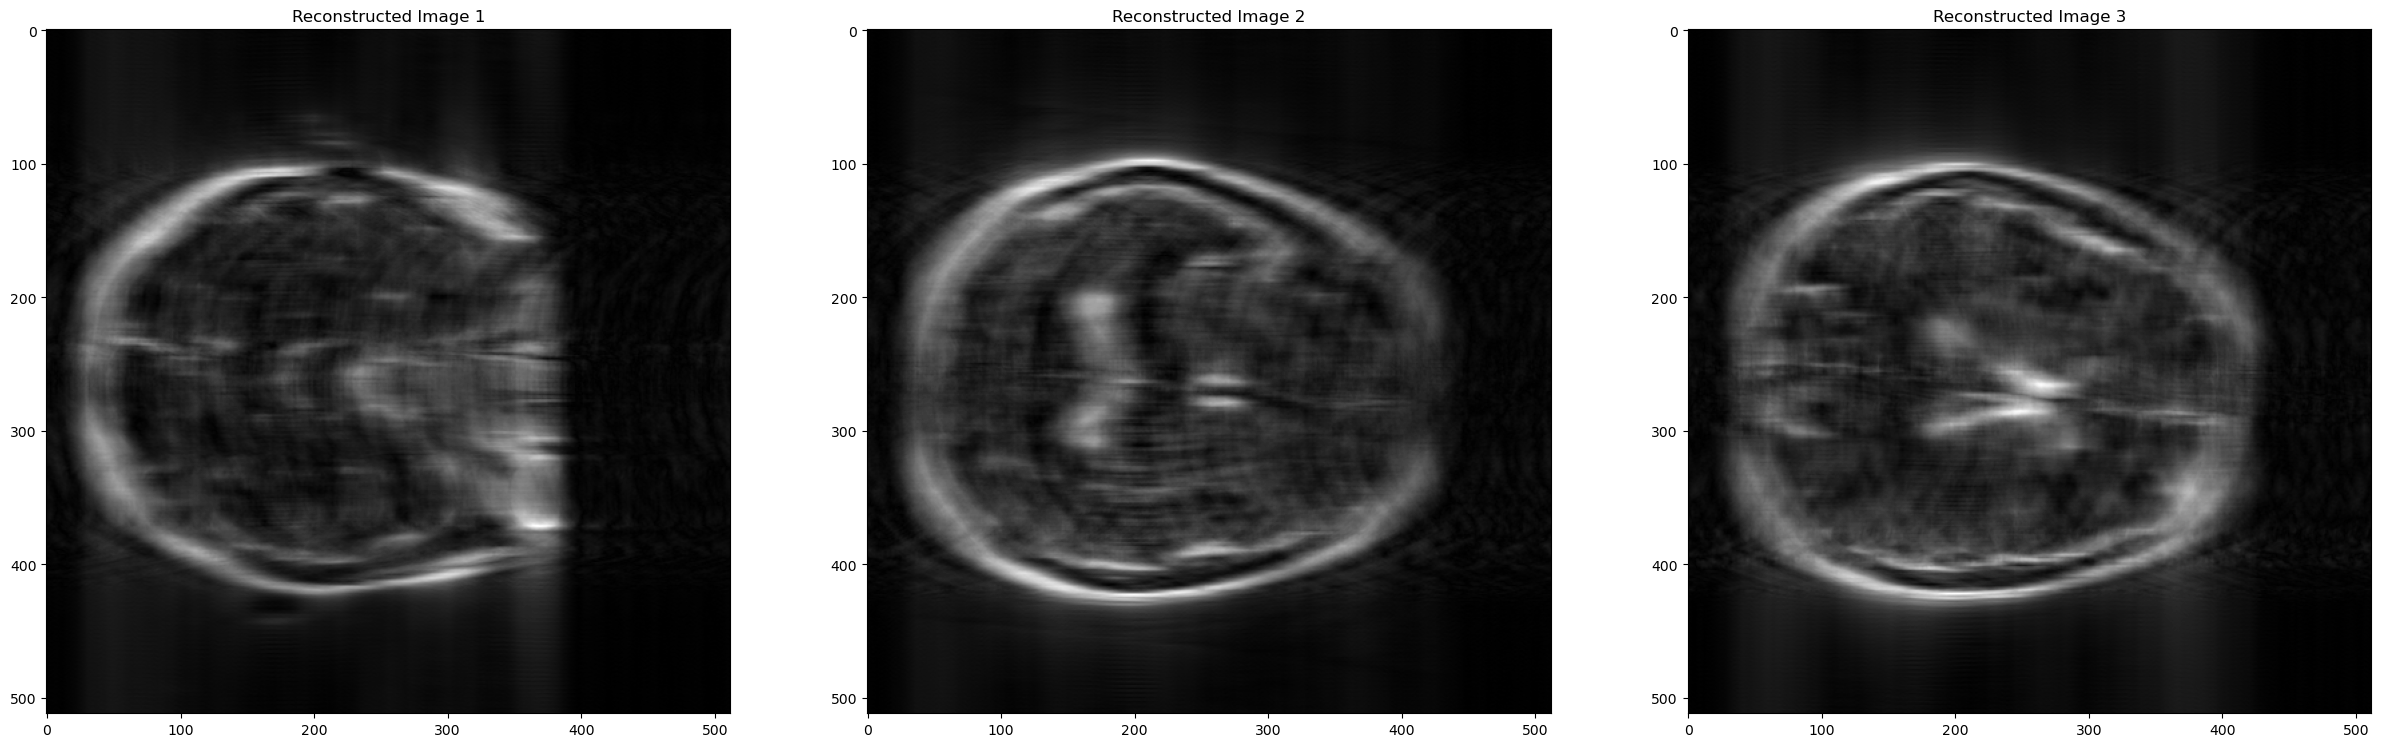

{}


In [8]:


image_path = r"O:\MICCAI2024\Real-Motion-01\datasets\motion01\real_motion\run01\sub-03_acq-t2tsepmcoff_rec-wore_run-01_T2w_slice7.png"
image2_path = r"O:\MICCAI2024\HAT-Motion\datasets\motion01\run02\motion\11.png"
image3_path = r"O:\MICCAI2024\Real-Motion-01\datasets\motion01\real_motion\run01\sub-03_acq-t2tsepmcoff_rec-wore_run-01_T2w_slice13.png"

image = Image.open(image_path).convert("L")  # 转换为灰度模式
image2 = Image.open(image2_path).convert("L")
image3 = Image.open(image3_path).convert("L")


# 获取图像的高度和宽度
width, height = image.size
# Combine images into a single RGB image
combined_image = np.array([np.array(image), np.array(image2), np.array(image3)])
print(combined_image.shape)
combined_image = torch.tensor(combined_image, dtype=torch.float32)
# combined_image = rotate(combined_image, 90, interpolation=InterpolationMode.BILINEAR)
combined_image = combined_image

noise_std_range = [2,3]

# padding50
options_log = {}



#def apply_motion(combined_image, raw_combined_image):
rounds = 128
K_data = torch.zeros_like(combined_image, dtype=torch.complex128)
for cur_phase in range(rounds):
    if cur_phase > rounds * (9/21) and cur_phase < rounds * (12/21):
        K_data = kspace_scan(combined_image, K_data, cur_phase, rounds)
    else:
        out_image = random_motion_transform(combined_image, width, height)
        out_image = center_crop(out_image, (512, 512))
        combined_result = out_image
        #print(combined_result.shape)

        K_data = kspace_scan(combined_result, K_data, cur_phase, rounds)
        #print(K_data.shape)


        # 水平对比展示原始图像和变形后的图像
        # Iterate through the stack of images and display them
        '''
        plt.figure(figsize=(30, 10))
        for i in range(combined_result.shape[0]):
            plt.subplot(1, 3, i + 1)
            plt.imshow(combined_result[i], cmap="gray")  # Assuming images are grayscale
            plt.title(f"Image {i+1}")
        plt.show()
        '''
# 将K空间数据转回图像
reconstructed_image = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(K_data, dim=(-2, -1)), dim=(-2, -1)))

plt.figure(figsize=(30, 10))
for cur_phase in range(K_data.shape[0]):
    plt.subplot(1, 3, cur_phase + 1)
    plt.imshow(np.log(np.abs(K_data[cur_phase]) + 1e-9), cmap="gray")  # Assuming images are grayscale
    plt.title(f"K-space Image {cur_phase+1}")
plt.show()

# 展示图像
plt.figure(figsize=(30, 10))
for cur_phase in range(reconstructed_image.shape[0]):
    plt.subplot(1, 3, cur_phase + 1)
    plt.imshow(reconstructed_image[cur_phase], cmap="gray")  # Assuming images are grayscale
    plt.title(f"Reconstructed Image {cur_phase+1}")
    cv2.imwrite(f"reconstructed_image_{cur_phase+1}_rounds{rounds}.png", reconstructed_image[cur_phase].numpy())
plt.show()
print('done')

# reconstructed_image = add_rician_noise(reconstructed_image, std=np.random.uniform(noise_std_range[0], noise_std_range[1]))


K_data = torch.fft.fft2(reconstructed_image, dim=(-2, -1))
K_data = torch.fft.fftshift(K_data, dim=(-2, -1))
# 定义mask的参数
center_fractions = [0.04]
accelerations = [8]
num_cols = 512
# 生成随机mask
random_mask = generate_random_mask(center_fractions, accelerations, num_cols)
# 将mask应用到张量上
# 将random mask在行上复制
mask = np.tile(random_mask, (1, 512))
print(mask.shape)
plt.figure(figsize=(30, 10))
for cur_phase in range(K_data.shape[0]):
    plt.subplot(1, 3, cur_phase + 1)
    plt.imshow(mask, cmap="gray")  # Assuming images are grayscale
    plt.title(f"Random Mask {cur_phase+1}")
plt.show()

K_data = K_data * random_mask.t()


plt.figure(figsize=(30, 10))
for cur_phase in range(K_data.shape[0]):
    plt.subplot(1, 3, cur_phase + 1)
    plt.imshow(np.log(np.abs(K_data[cur_phase]) + 1e-9), cmap="gray")  # Assuming images are grayscale
    plt.title(f"K-space Image {cur_phase+1}")
plt.show()

reconstructed_image = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(K_data, dim=(-2, -1)), dim=(-2, -1)))

# 展示图像
plt.figure(figsize=(30, 10))
for cur_phase in range(reconstructed_image.shape[0]):
    plt.subplot(1, 3, cur_phase + 1)
    plt.imshow(reconstructed_image[cur_phase], cmap="gray")  # Assuming images are grayscale
    plt.title(f"Reconstructed Image {cur_phase+1}")
plt.show()

print(options_log)

In [15]:
import os
from PIL import Image
import numpy as np
import torch
def reconstruct_and_save_image(image_path: str, save_folder: str = "reconstructed_images"):
    # Load the image
    image = Image.open(image_path).convert("L")
    width, height = image.size
    combined_image = np.array(image)
    combined_image = torch.tensor(combined_image, dtype=torch.float32)

    # Fourier transform
    K_data = torch.fft.fft2(combined_image, dim=(-2, -1))
    K_data = torch.fft.fftshift(K_data, dim=(-2, -1))

    # Generate random mask
    center_fractions_range = [0.04, 0.08]
    accelerations_range = [2, 4]
    center_fractions = 0.08
    accelerations = 4
    #center_fractions = np.random.uniform(center_fractions_range[0], center_fractions_range[1])
    #accelerations = np.random.randint(accelerations_range[0], accelerations_range[1])
    horizontal_mask_prob = 0.0
    if np.random.uniform(0, 1) < horizontal_mask_prob:
        random_mask = generate_random_mask([center_fractions], [accelerations], K_data.shape[-2])
        K_data = K_data * random_mask
        mask_label = "wh"
    else:
        random_mask = generate_random_mask([center_fractions], [accelerations], K_data.shape[-1])
        K_data = K_data * random_mask.t()
        mask_label = "woh"

    # Reconstruct image
    reconstructed_image = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(K_data, dim=(-2, -1)), dim=(-2, -1)))

    # Construct output filename
    file_name, file_extension = os.path.splitext(os.path.basename(image_path))
    output_filename = f"{file_name}.png"
    output_path = os.path.join(save_folder, output_filename)

    # Save the reconstructed image
    reconstructed_image_pil = Image.fromarray(reconstructed_image.numpy().astype(np.uint8))
    os.makedirs(save_folder, exist_ok=True)
    reconstructed_image_pil.save(output_path)
    print(f"Reconstructed image saved at: {output_path}")

# 输入和输出文件夹路径
input_folder = r"O:\MICCAI2024\Real-Motion-01\datasets\motion02\run02"
output_folder = r"O:\MICCAI2024\Real-Motion-01\datasets\motion02\run02_vf4"

# 确保输出文件夹存在
os.makedirs(output_folder, exist_ok=True)

# 获取输入文件夹内的所有图像文件路径
image_files = [f for f in os.listdir(input_folder) if f.endswith(".png")]

# 遍历图像文件，并对每个图像应用重建函数
for image_file in image_files:
    input_image_path = os.path.join(input_folder, image_file)
    output_image_path = output_folder

    # 调用重建函数
    reconstruct_and_save_image(input_image_path, output_image_path)

print("Reconstruction of all images complete.")


Center Fraction: 0.08, Acceleration: 4
Number of True values in the mask: 135
Reconstructed image saved at: O:\MICCAI2024\Real-Motion-01\datasets\motion02\run02_vf4\sub-01_slice0.png
Center Fraction: 0.08, Acceleration: 4
Number of True values in the mask: 136
Reconstructed image saved at: O:\MICCAI2024\Real-Motion-01\datasets\motion02\run02_vf4\sub-01_slice1.png
Center Fraction: 0.08, Acceleration: 4
Number of True values in the mask: 129
Reconstructed image saved at: O:\MICCAI2024\Real-Motion-01\datasets\motion02\run02_vf4\sub-01_slice10.png
Center Fraction: 0.08, Acceleration: 4
Number of True values in the mask: 128
Reconstructed image saved at: O:\MICCAI2024\Real-Motion-01\datasets\motion02\run02_vf4\sub-01_slice11.png
Center Fraction: 0.08, Acceleration: 4
Number of True values in the mask: 124
Reconstructed image saved at: O:\MICCAI2024\Real-Motion-01\datasets\motion02\run02_vf4\sub-01_slice12.png
Center Fraction: 0.08, Acceleration: 4
Number of True values in the mask: 125
Reco

In [10]:
from PIL import Image
import os

def rotate_images_in_directory(directory_path):
    # 获取目录中所有的文件名
    file_names = os.listdir(directory_path)

    # 循环处理每个文件
    for file_name in file_names:
        # 检查文件是否为图像文件
        if file_name.endswith(".png") or file_name.endswith(".jpg"):
            # 构建完整的文件路径
            file_path = os.path.join(directory_path, file_name)

            # 打开图像文件
            image = Image.open(file_path)

            # 对图像进行旋转操作
            rotated_image = image.rotate(-90, expand=True)  # 顺时针旋转90度，expand=True保证图像不被裁剪

            # 保存旋转后的图像，覆盖原始文件
            rotated_image.save(file_path)

            print(f"Rotated image {file_name} successfully.")

# 调用示例
directory_path = r"O:\MICCAI2024\Real-Motion-01\datasets\motion02\run021\run02"
rotate_images_in_directory(directory_path)


Rotated image sub-02_slice0.png successfully.


Rotated image sub-02_slice1.png successfully.
Rotated image sub-02_slice10.png successfully.
Rotated image sub-02_slice11.png successfully.
Rotated image sub-02_slice12.png successfully.
Rotated image sub-02_slice13.png successfully.
Rotated image sub-02_slice14.png successfully.
Rotated image sub-02_slice15.png successfully.
Rotated image sub-02_slice16.png successfully.
Rotated image sub-02_slice17.png successfully.
Rotated image sub-02_slice18.png successfully.
Rotated image sub-02_slice19.png successfully.
Rotated image sub-02_slice2.png successfully.
Rotated image sub-02_slice20.png successfully.
Rotated image sub-02_slice21.png successfully.
Rotated image sub-02_slice3.png successfully.
Rotated image sub-02_slice4.png successfully.
Rotated image sub-02_slice5.png successfully.
Rotated image sub-02_slice6.png successfully.
Rotated image sub-02_slice7.png successfully.
Rotated image sub-02_slice8.png successfully.
Rotated image sub-02_slice9.png successfully.


In [11]:
import os

def remove_substring_from_filenames(directory_path, substring):
    # 获取目录中所有的文件名
    file_names = os.listdir(directory_path)

    # 循环处理每个文件
    for file_name in file_names:
        # 构建完整的文件路径
        file_path = os.path.join(directory_path, file_name)

        # 检查文件名是否包含指定的子字符串
        if substring in file_name:
            # 构建新的文件名，将子字符串替换为空字符串
            new_file_name = file_name.replace(substring, "")

            # 构建新的文件路径
            new_file_path = os.path.join(directory_path, new_file_name)

            # 重命名文件
            os.rename(file_path, new_file_path)

            print(f"Renamed file {file_name} to {new_file_name} successfully.")

# 调用示例
directory_path = r"O:\MICCAI2024\Real-Motion-01\datasets\motion02\gt320_motion_f4"
substring = "_gt320"
remove_substring_from_filenames(directory_path, substring)


In [29]:
import os

folder_path = r'O:\MICCAI2024\Real-Motion-01\datasets\motion02\run01_v'  # 文件夹路径

# 遍历文件夹中的文件
for filename in os.listdir(folder_path):
    if filename.endswith('.png'):
        # 构建新文件名
        new_filename = filename.replace('.png', '_v.png')
        # 构建完整的文件路径
        old_file_path = os.path.join(folder_path, filename)
        new_file_path = os.path.join(folder_path, new_filename)
        # 重命名文件
        os.rename(old_file_path, new_file_path)
        print(f'Renamed: {filename} -> {new_filename}')


Renamed: sub-01_slice0.png -> sub-01_slice0_v.png
Renamed: sub-01_slice1.png -> sub-01_slice1_v.png
Renamed: sub-01_slice10.png -> sub-01_slice10_v.png
Renamed: sub-01_slice11.png -> sub-01_slice11_v.png
Renamed: sub-01_slice12.png -> sub-01_slice12_v.png
Renamed: sub-01_slice13.png -> sub-01_slice13_v.png
Renamed: sub-01_slice14.png -> sub-01_slice14_v.png
Renamed: sub-01_slice15.png -> sub-01_slice15_v.png
Renamed: sub-01_slice16.png -> sub-01_slice16_v.png
Renamed: sub-01_slice17.png -> sub-01_slice17_v.png
Renamed: sub-01_slice18.png -> sub-01_slice18_v.png
Renamed: sub-01_slice19.png -> sub-01_slice19_v.png
Renamed: sub-01_slice2.png -> sub-01_slice2_v.png
Renamed: sub-01_slice20.png -> sub-01_slice20_v.png
Renamed: sub-01_slice21.png -> sub-01_slice21_v.png
Renamed: sub-01_slice3.png -> sub-01_slice3_v.png
Renamed: sub-01_slice4.png -> sub-01_slice4_v.png
Renamed: sub-01_slice5.png -> sub-01_slice5_v.png
Renamed: sub-01_slice6.png -> sub-01_slice6_v.png
Renamed: sub-01_slice7.png